In [1]:
import numpy as np
import glob
import torch
import torch.nn as nn
import xarray as xr
import os
import matplotlib.pyplot as plt

from neural_network.mlp import MLP
from neural_network.train import double_logistic_function, MEANS, STDS, T_SCALE, YEARS_IN_TRAIN, YEARS_IN_TEST
from neural_network.helpers import get_doy, check_missing_timestamps, get_split_indices, NUM_DATAPOINTS_PER_YEAR, START_YEAR, END_YEAR, H, W

In [ ]:
def inference(encoder_path, cube_dir, features):

    filepaths = sorted(list(glob.glob(os.path.join(cube_dir, "*_raw.nc"))))
    device = "cuda"

    if features is None:
        features = ["dem", "fc", "fh", "slope", "easting", "northing", "twi", "rugg", "curv", "press_mean", "press_std", "temp_mean", "temp_std", "precip_mean", "precip_std"]
    elif isinstance(features, str):
        features = features.split(",")

    train_indices = get_split_indices(YEARS_IN_TRAIN)
    test_indices = get_split_indices(YEARS_IN_TEST)

    encoder = MLP(d_in=len(features), d_out=8, n_blocks=8, d_block=256, dropout=0, skip_connection=True).to(device)
    encoder.load_state_dict(torch.load(encoder_path, weights_only=True))
    encoder.eval()

    means = torch.tensor([MEANS[f] for f in features], dtype=float, device=device).unsqueeze(1).unsqueeze(1)
    stds = torch.tensor([STDS[f] for f in features], dtype=float, device=device).unsqueeze(1).unsqueeze(1)

    train_below = np.zeros(NUM_DATAPOINTS_PER_YEAR, dtype=int)
    train_in = np.zeros(NUM_DATAPOINTS_PER_YEAR, dtype=int)
    train_above = np.zeros(NUM_DATAPOINTS_PER_YEAR, dtype=int)

    test_below = np.zeros(NUM_DATAPOINTS_PER_YEAR, dtype=int)
    test_in = np.zeros(NUM_DATAPOINTS_PER_YEAR, dtype=int)
    test_above = np.zeros(NUM_DATAPOINTS_PER_YEAR, dtype=int)

    for i, path in enumerate(filepaths):
        with torch.no_grad():

            try:
                minicube = xr.open_dataset(path, engine="h5netcdf")
            except OSError:
                continue

            missing_dates = check_missing_timestamps(minicube)
            if missing_dates:
                minicube = minicube.reindex(
                    time=np.sort(np.concatenate([minicube.time.values, missing_dates]))
                )

            try:
                ndvi = minicube.s2_ndvi.where((minicube.s2_mask == 0) & minicube.s2_SCL.isin([1, 2, 4, 5, 6, 7])).values
                forest_mask = (minicube.FOREST_MASK.values > 0.8)
            except AttributeError:
                continue

            # convert to torch
            ndvi = torch.from_numpy(ndvi).to(device)
            doy = torch.from_numpy(get_doy(minicube.time.values)).to(device)
            forest_mask = torch.from_numpy(forest_mask).to(device)

            # get train
            ndvi_train = ndvi[train_indices][:, forest_mask].permute(1, 0)
            doy_train = doy[train_indices]

            # get test
            ndvi_test = ndvi[test_indices][:, forest_mask].permute(1, 0)
            doy_test = doy[test_indices]

            # features for network
            dem = torch.from_numpy(minicube.DEM.values).to(device)
            fc = torch.from_numpy(minicube.FC.values).to(device)
            fh = torch.from_numpy(minicube.FH.values).to(device)
            slope = torch.from_numpy(minicube.slope.values).to(device)
            easting = torch.from_numpy(minicube.easting.values).to(device)
            northing = torch.from_numpy(minicube.northing.values).to(device)
            twi = torch.from_numpy(minicube.twi.values).to(device)
            rugg = torch.from_numpy(minicube.rugg.values).to(device)
            curv = torch.from_numpy(minicube.curv.values).to(device)

            pressure = torch.from_numpy(minicube.era5_sp.values[train_indices]).to(device)
            annual_pressure = torch.nanmean(pressure.view(END_YEAR - START_YEAR, NUM_DATAPOINTS_PER_YEAR, H, W), axis=0)
            press_mean = torch.mean(annual_pressure, axis=0)
            press_std = torch.std(annual_pressure, axis=0)

            temperature = torch.from_numpy(minicube.era5_t2m.values[train_indices]).to(device)
            annual_temperature = torch.nanmean(temperature.view(END_YEAR - START_YEAR, NUM_DATAPOINTS_PER_YEAR, H, W), axis=0)
            temp_mean = torch.mean(annual_temperature, axis=0)
            temp_std = torch.std(annual_temperature, axis=0)

            precipitation = torch.from_numpy(minicube.era5_tp.values[train_indices]).to(device)
            annual_precipitation = torch.nanmean(precipitation.view(END_YEAR - START_YEAR, NUM_DATAPOINTS_PER_YEAR, H, W), axis=0)
            precip_mean = torch.mean(annual_precipitation, axis=0)
            precip_std = torch.std(annual_precipitation, axis=0)

            fc[fc == -9999] = torch.nan
            inp = torch.stack([dem, fc, fh, slope, easting, northing, twi, rugg, curv, press_mean, press_std, temp_mean, temp_std, precip_mean, precip_std], axis=0)  # 11 x H x W
            inp = (inp - means) / stds
            inp = torch.nan_to_num(inp, nan=0.0)

            # only forward forest pixels
            masked_inp = inp[:, forest_mask]
            masked_inp = masked_inp.permute(1, 0)  # B x 11

            preds = encoder(masked_inp.float())
            paramsl = preds[:, [0, 1, 2, 3, 4, 5]]
            paramsu = torch.cat([preds[:, [0, 1, 2, 3]], preds[:, [4, 5]] + nn.functional.softplus(preds[:, [6, 7]])], axis=1)

            bs = forest_mask.sum()

            t_train = doy_train * T_SCALE
            ndvi_lower_pred_train = double_logistic_function(t_train, paramsl)
            ndvi_upper_pred_train = double_logistic_function(t_train, paramsu)

            ndvi_lower_pred_train = ndvi_lower_pred_train.view(bs, len(YEARS_IN_TRAIN), NUM_DATAPOINTS_PER_YEAR).contiguous().view(-1, NUM_DATAPOINTS_PER_YEAR)
            ndvi_upper_pred_train = ndvi_upper_pred_train.view(bs, len(YEARS_IN_TRAIN), NUM_DATAPOINTS_PER_YEAR).contiguous().view(-1, NUM_DATAPOINTS_PER_YEAR)
            ndvi_train = ndvi_train.view(bs, len(YEARS_IN_TRAIN), NUM_DATAPOINTS_PER_YEAR).contiguous().view(-1, NUM_DATAPOINTS_PER_YEAR)
            ndvi_train_mask = ~torch.isnan(ndvi_train)

            train_below += torch.sum((ndvi_train < ndvi_lower_pred_train) * ndvi_train_mask, dim=0).cpu().numpy()
            train_in += torch.sum(((ndvi_train >= ndvi_lower_pred_train) & (ndvi_train <= ndvi_upper_pred_train)) * ndvi_train_mask, dim=0).cpu().numpy()
            train_above += torch.sum((ndvi_train > ndvi_upper_pred_train) * ndvi_train_mask, dim=0).cpu().numpy()

            t_test = doy_test * T_SCALE
            ndvi_lower_pred_test = double_logistic_function(t_test, paramsl)
            ndvi_upper_pred_test = double_logistic_function(t_test, paramsu)

            ndvi_lower_pred_test = ndvi_lower_pred_test.view(bs, len(YEARS_IN_TEST), NUM_DATAPOINTS_PER_YEAR).contiguous().view(-1, NUM_DATAPOINTS_PER_YEAR)
            ndvi_upper_pred_test = ndvi_upper_pred_test.view(bs, len(YEARS_IN_TEST), NUM_DATAPOINTS_PER_YEAR).contiguous().view(-1, NUM_DATAPOINTS_PER_YEAR)
            ndvi_test = ndvi_test.view(bs, len(YEARS_IN_TEST), NUM_DATAPOINTS_PER_YEAR).contiguous().view(-1, NUM_DATAPOINTS_PER_YEAR)
            ndvi_test_mask = ~torch.isnan(ndvi_test)

            test_below += torch.sum((ndvi_test < ndvi_lower_pred_test) * ndvi_test_mask, dim=0).cpu().numpy()
            test_in += torch.sum(((ndvi_test >= ndvi_lower_pred_test) & (ndvi_test <= ndvi_upper_pred_test)) * ndvi_test_mask, dim=0).cpu().numpy()
            test_above += torch.sum((ndvi_test > ndvi_upper_pred_test) * ndvi_test_mask, dim=0).cpu().numpy()

            #
            # plot the first iteration
            #
            if i == 0:
                t_plot = torch.linspace(0, 365, 1000).unsqueeze(0) * T_SCALE

                ndvi_lower_plot = double_logistic_function(t_plot.repeat(paramsl.shape[0], 1), paramsl.cpu())
                ndvi_upper_plot = double_logistic_function(t_plot.repeat(paramsu.shape[0], 1), paramsu.cpu())

                masked_ndvi_test = ndvi_test.cpu()
                masked_nan_mask_test = torch.isnan(masked_ndvi_test)
                
                fig, ax = plt.subplots(6, 2, figsize=(15, 18))
                random_indices = np.random.choice(np.arange(paramsl.shape[0]), size=12, replace=False)
                for pl_idx, bi in enumerate(random_indices):

                    row, col = divmod(pl_idx, 2)

                    iqr = ndvi_upper_plot[bi] - ndvi_lower_plot[bi]

                    masked_ndvi_test_i = masked_ndvi_test[bi][~masked_nan_mask_test[bi]]
                    masked_doy_test_i = doy_test[~masked_nan_mask_test[bi]].cpu()
                    ax[row, col].scatter(masked_doy_test_i, masked_ndvi_test_i, label='Observed NDVI')
                    ax[row, col].fill_between(t_plot[0] / T_SCALE, ndvi_lower_plot[bi], ndvi_upper_plot[bi], alpha=0.2, color='red')
                    ax[row, col].plot(t_plot[0] / T_SCALE, ndvi_lower_plot[bi] - 1.5 * iqr, c='k')
                    ax[row, col].plot(t_plot[0] / T_SCALE, ndvi_upper_plot[bi] + 1.5 * iqr, c='k')
                    ax[row, col].set_ylabel("NDVI")
                    ax[row, col].set_ylabel("DOY")
                    ax[row, col].set_ylim(-0.1, 1)

                fig.show()

        if (i + 1) % 100 == 0:
            print("done {}".format(i + 1))

    return train_below, train_in, train_above, test_below, test_in, test_above

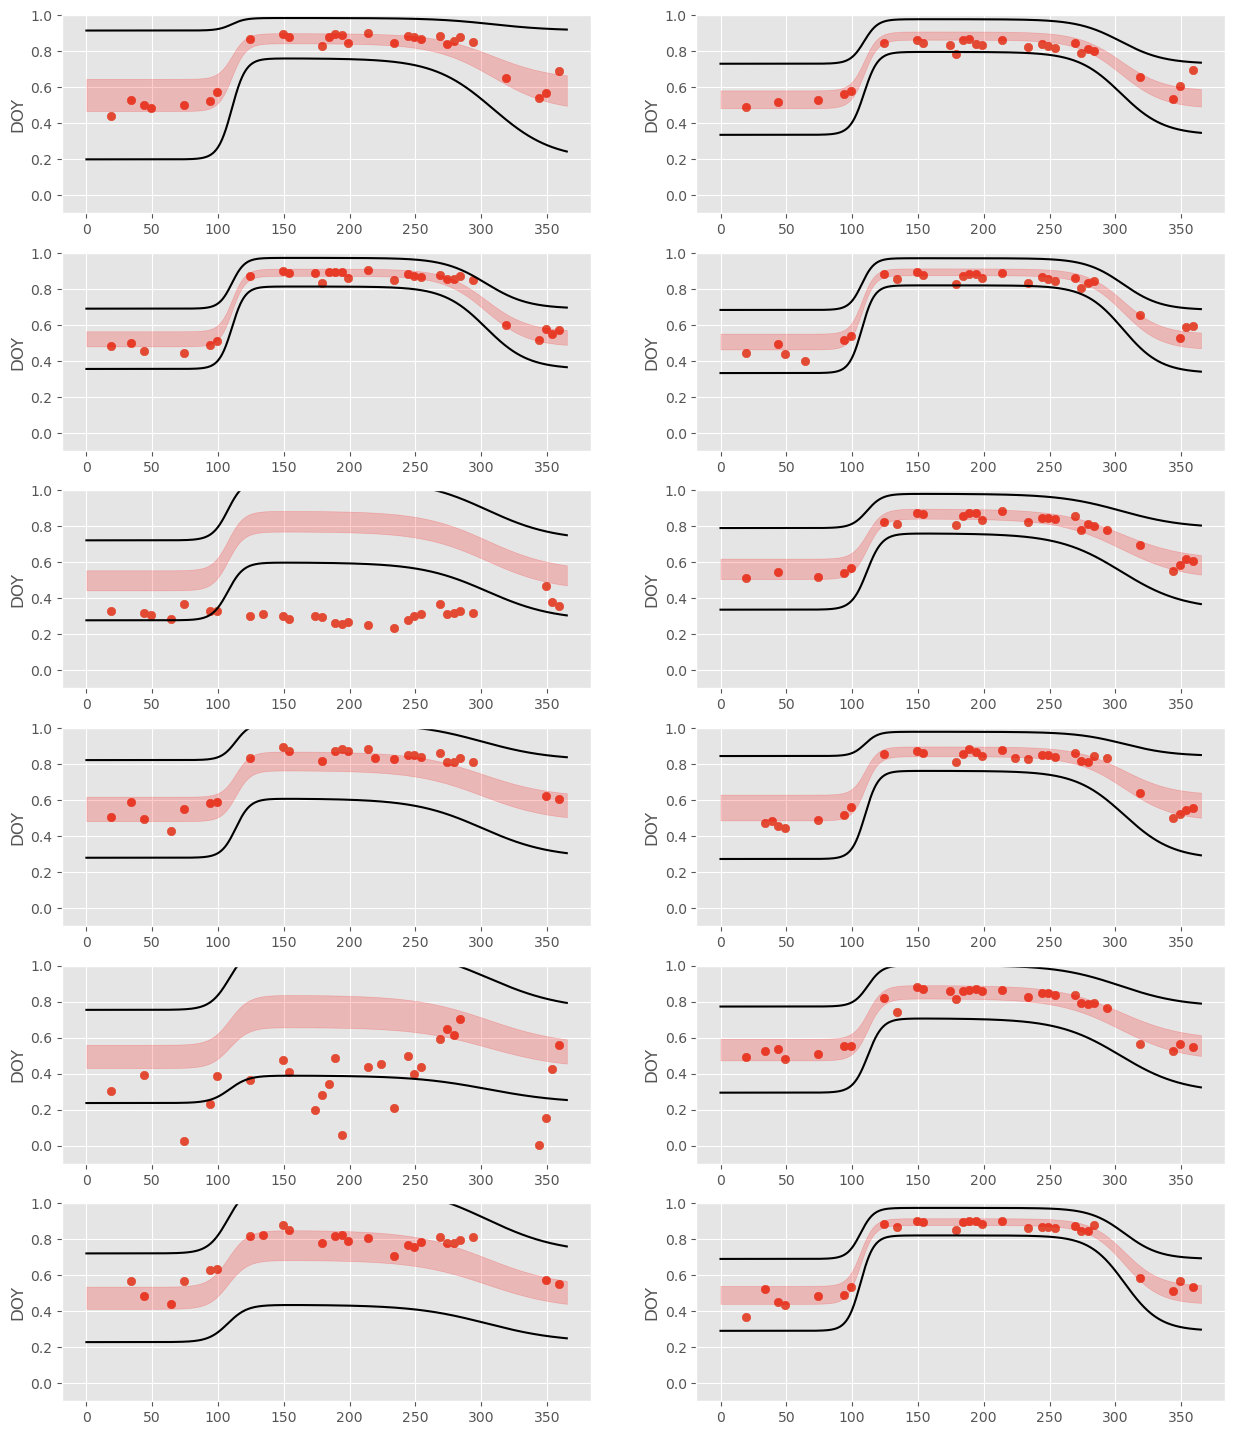

In [45]:
train_below, train_in, train_above, test_below, test_in, test_above = inference("/data_2/scratch/dbrueggemann/output/encoder_nolon_era_500k.pt", "/data_2/dimpeo/cubes", None)

/tmp/ipykernel_1063353/3752884023.py:57: RuntimeWarning: invalid value encountered in divide
  plot_and_hist(np.arange(NUM_DATAPOINTS_PER_YEAR), (test_below + test_in) / (test_below + test_in + test_above), test_below / (test_below + test_in + test_above), ax2, ax_histy2)


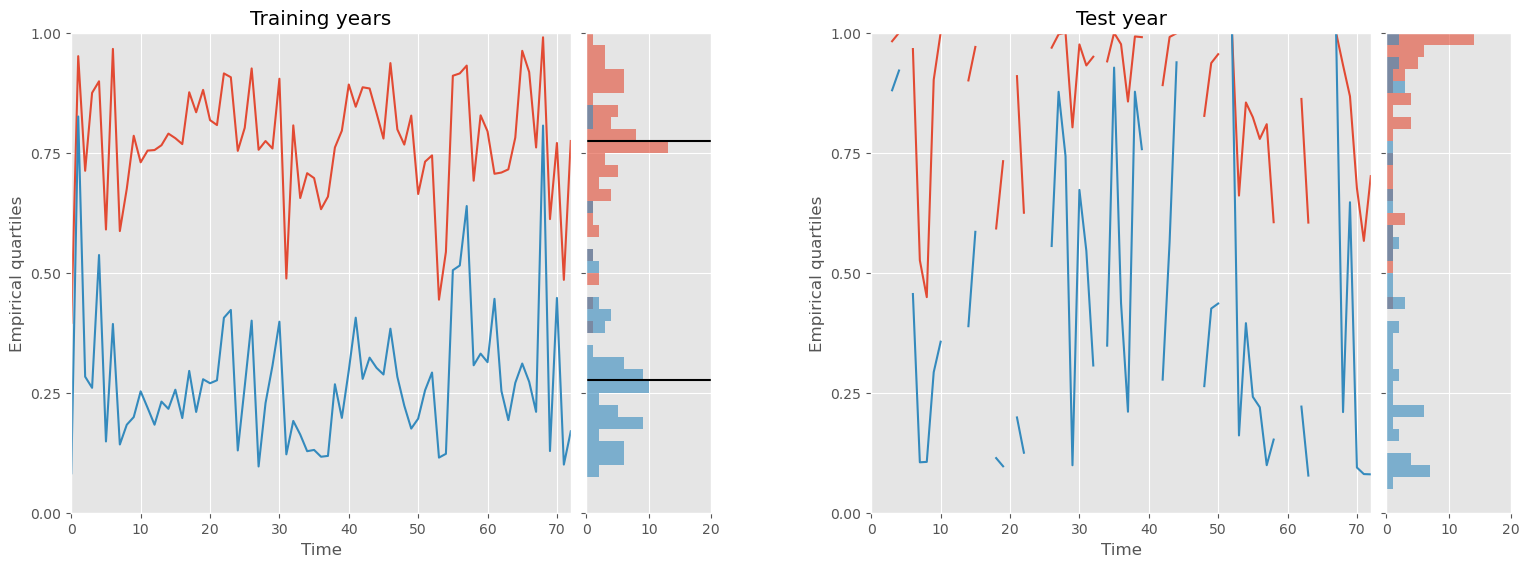

In [43]:
plt.style.use('ggplot')

def plot_and_hist(x, y1, y2, ax, ax_histy):

    # no labels
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.plot(x, y1)
    ax.plot(x, y2)
    xmin, xmax = min(x), max(x)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(0, 1)

    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_ylabel("Empirical quartiles")
    ax.set_xlabel("Time")

    # now determine nice limits by hand:
    binwidth = 0.025
    xymax1 = max(np.max(np.abs(x)), np.max(np.abs(y1)))
    lim1 = (int(xymax1/binwidth) + 1) * binwidth
    bins1 = np.arange(-lim1, lim1 + binwidth, binwidth)
    xymax2 = max(np.max(np.abs(x)), np.max(np.abs(y2)))
    lim2 = (int(xymax2/binwidth) + 1) * binwidth
    bins2 = np.arange(-lim2, lim2 + binwidth, binwidth)
    ax_histy.hist(y1, bins=bins1, orientation='horizontal', alpha=0.6)
    ax_histy.hist(y2, bins=bins2, orientation='horizontal', alpha=0.6)

    mean1 = y1.mean()
    ax_histy.hlines(mean1, xmin=0, xmax=20, color='k')
    mean2 = y2.mean()
    ax_histy.hlines(mean2, xmin=0, xmax=20, color='k')
    ax_histy.set_xlim(0, 20)

fig = plt.figure(figsize=(16, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs1 = fig.add_gridspec(1, 2,  width_ratios=(4, 1),
                      left=0.05, right=0.45, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs1[0])
ax_histy = fig.add_subplot(gs1[1], sharey=ax)

plot_and_hist(np.arange(NUM_DATAPOINTS_PER_YEAR), (train_below + train_in) / (train_below + train_in + train_above), train_below / (train_below + train_in + train_above), ax, ax_histy)
ax.set_title("Training years")

gs2 = fig.add_gridspec(1, 2,  width_ratios=(4, 1),
                      left=0.55, right=0.95, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax2 = fig.add_subplot(gs2[0])
ax_histy2 = fig.add_subplot(gs2[1], sharey=ax2)

plot_and_hist(np.arange(NUM_DATAPOINTS_PER_YEAR), (test_below + test_in) / (test_below + test_in + test_above), test_below / (test_below + test_in + test_above), ax2, ax_histy2)

ax2.set_title("Test year")

fig.show()